# SARIMAX

Разберем пример из документации https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO

pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

Считаем данные для задачи по потреблению некоторого продукта (consumption).

In [ ]:
friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content

raw = pd.read_stata(BytesIO(friedman2))
raw.index = raw.time
raw.index.freq = "QS-OCT"
data = raw.loc[:'1981']

data.head()

,m2,time,m1,consump,pc92
time,,,,,
1946-01-01,NaN,1946-01-01,NaN,134.899994,NaN
1946-04-01,NaN,1946-04-01,NaN,140.100006,NaN
1946-07-01,NaN,1946-07-01,NaN,148.899994,NaN
1946-10-01,NaN,1946-10-01,NaN,153.199997,NaN
1947-01-01,NaN,1947-01-01,NaN,156.600006,912.099976


In [ ]:
data.tail()

,m2,time,m1,consump,pc92
time,,,,,
1980-10-01,1601.099976,1980-10-01,408.920013,1836.800049,3034.199951
1981-01-01,1638.000000,1981-01-01,418.920013,1890.300049,3045.600098
1981-04-01,1670.550049,1981-04-01,423.899994,1923.500000,3045.800049
1981-07-01,1708.380005,1981-07-01,427.910004,1967.400024,3058.800049
1981-10-01,1756.189941,1981-10-01,436.790009,1983.900024,3035.300049


У нас есть эндогенные и экзогенные переменные в данных:

* эндогенные - сам временной ряд, столбец `consump`
* экзогенные - дополнительные временные ряды-факторы, будем использовать столбец `m2`

In [ ]:
# Variables
endog = data.loc['1959':, 'consump']
exog = sm.add_constant(data.loc['1959':, 'm2'])
nobs = endog.shape[0]

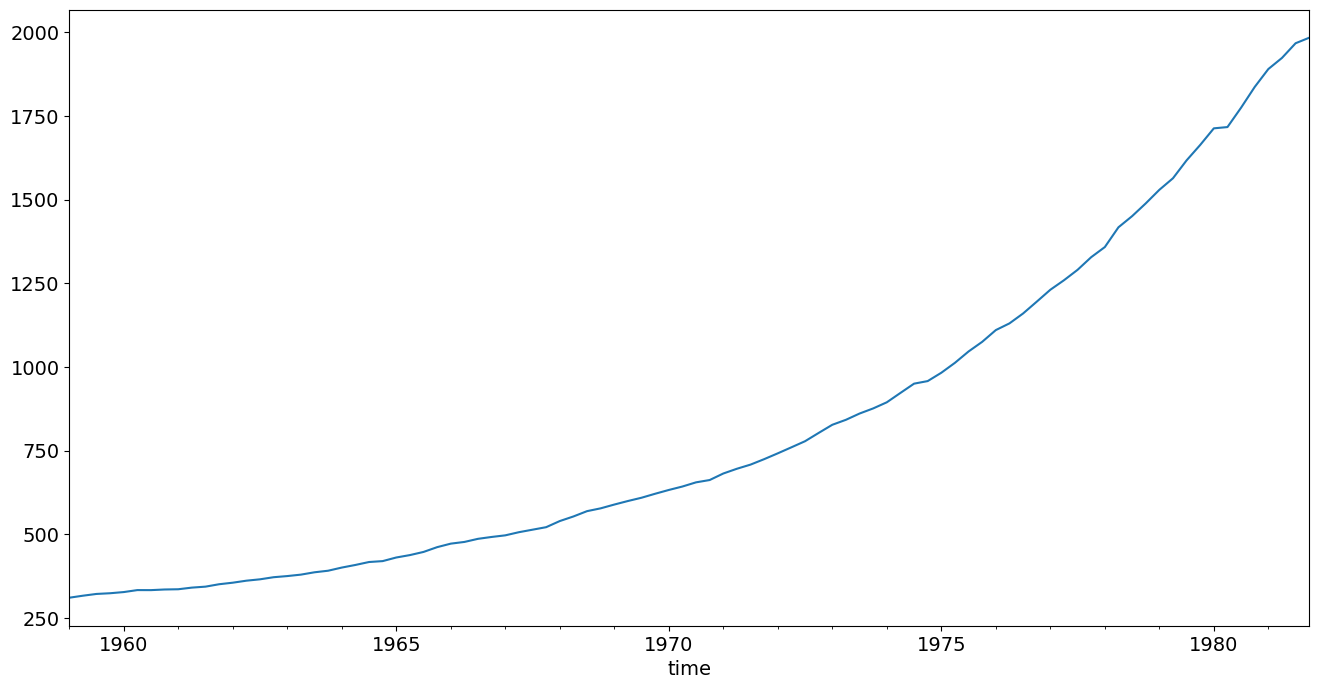

In [ ]:
endog.plot();

Обучим SARIMAX модель на части данных (до 1978 года)

In [ ]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog.loc[:'1978-01-01'], exog=exog.loc[:'1978-01-01'], order=(1,0,1))
fit_res = mod.fit(disp=False, maxiter=250)
print(fit_res.summary())

                               SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                   77
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -243.316
Date:                Mon, 12 Aug 2024   AIC                            496.633
Time:                        18:20:44   BIC                            508.352
Sample:                    01-01-1959   HQIC                           501.320
                         - 01-01-1978                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6782     18.492      0.037      0.971     -35.565      36.922
m2             1.0379      0.021     50.329      0.000       0.997       1.078
ar.L1          0.8775      0.059     14.859      0.0

Получим прогнозы модели на всех данных.

In [ ]:
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,0,1))
res = mod.filter(fit_res.params)

Если не передавать в функцию get_prediction ничего, то получаем `one-step-ahead in-sample` предсказание, то есть каждый раз предсказываем на шаг вперед относительно известного верного прогноза. На всей выборке.

In [ ]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

Гиперпараметр `dynamic` задает стартовую точку. Здесь получим предсказания, начиная с 1978 года.

Здесь уже модель не смотрит на правильные ответы, а ориентируется только на свои прогнозы.

In [ ]:
# Dynamic predictions
predict_dy = res.get_prediction(dynamic='1978-01-01')
predict_dy_ci = predict_dy.conf_int()

Нарисуем one-step-ahead прогноз и динамический прогноз на одном графике для сравнения.

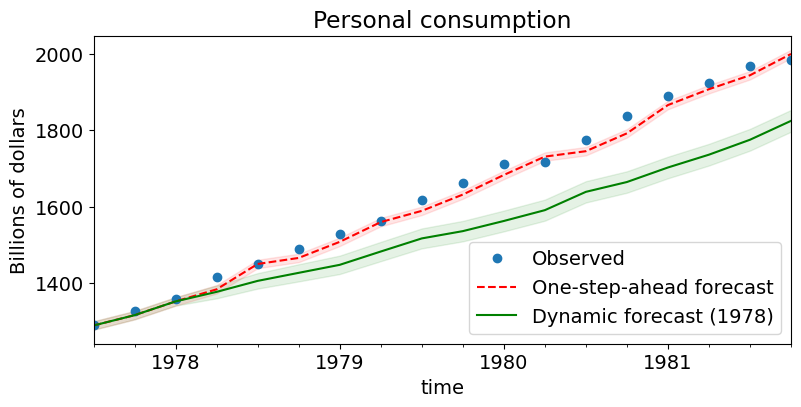

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
data.loc['1977-07-01':, 'consump'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
ci = predict_dy_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')